In [44]:
import pandas as pd
import numpy as np

# Read data from CSV files
bcwlist = pd.read_excel('data/bcwlist.xlsx', skiprows=2)
crsp = pd.read_csv('data/cleaned_crsp.csv')

# Convert date columns to datetime format
crsp['date'] = pd.to_datetime(crsp['date'])

# Convert RET and PRC columns to numeric data types and handle invalid values
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')

# Group by date and permno, and aggregate using the last valid observation
crsp = crsp.groupby(['PERMNO', pd.Grouper(key='date', freq='M')]).last().reset_index()

import warnings
warnings.filterwarnings('ignore')

In [46]:
# Function to calculate weights for equal- and value-weighted portfolios
def get_weights(data, weight_type):
    if weight_type == 'equal':
        weights = np.ones(len(data)) / len(data)
    elif weight_type == 'value':
        weights = data['SHROUT'] * data['PRC']
        weights /= weights.sum()
    return weights

# Function to calculate monthly returns for the portfolio
def calculate_monthly_returns(data, weights):
    returns = (data['RET'] * weights).sum()
    return returns

In [105]:
ff3

,Mkt-RF,SMB,HML,RF
Date,,,,
1984-02,-4.82,-1.69,3.33,0.71
1984-03,0.63,0.07,0.46,0.73
1984-04,-0.51,-1.16,1.20,0.81
1984-05,-5.97,0.06,0.31,0.78
1984-06,1.82,-0.30,-2.66,0.75
...,...,...,...,...
2019-07,1.19,-1.93,0.47,0.19
2019-08,-2.58,-2.37,-4.77,0.16
2019-09,1.43,-0.97,6.74,0.18


In [121]:
def build_portfolios(bcwlist, crsp):
    portfolio_returns = {'equal': [], 'value': []}
    current_stocks = []
    # Get the unique years in bcwlist
    years = bcwlist['year'].unique()
    years = sorted(years, key=lambda year: int(year))
    print(years)

    for i in range(len(years) - 1):
        start_date = pd.Timestamp(year=years[i], month=1, day=1)
        end_date = pd.Timestamp(year=years[i + 1], month=1, day=1)

        period_bcws = bcwlist[bcwlist['year'] == start_date.year]
        period_crsp = crsp[(crsp['date'].dt.year >= start_date.year) & (crsp['date'].dt.year < end_date.year)]

        for weight_type in ['equal', 'value']:
            portfolio_value = 1
            portfolio_value_history = []

            # Get the list of companies for the current year
            companies = period_bcws['permno'].values
            stock_data = period_crsp[(period_crsp['date'] == start_date + pd.DateOffset(months=1)) & period_crsp['PERMNO'].isin(companies)]

            for date in pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date + pd.DateOffset(months=-1), freq='M'):
                if not stock_data.empty:
                    # Calculate weights
                    weights = get_weights(stock_data, weight_type)

                    # Calculate monthly returns
                    stock_data['monthly_return'] = stock_data['RET'] * weights

                    # Add new stocks and remove delisted stocks
                    stock_data = stock_data.dropna(subset=['monthly_return'])

                    # Calculate portfolio value and store the value history
                    portfolio_value *= (1 + stock_data['monthly_return'].sum())
                    portfolio_value_history.append(portfolio_value)

                # Get stock data closest to the current date
                stock_data = period_crsp[(period_crsp['date'] == date + pd.DateOffset(months=1)) & period_crsp['PERMNO'].isin(companies)]

            portfolio_returns[weight_type].append(pd.DataFrame(portfolio_value_history, columns=['return'], index=pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date + pd.DateOffset(months=-1), freq='M').to_period('M')))

    # Concatenate dataframes
    for weight_type in ['equal', 'value']:
        portfolio_returns[weight_type] = pd.concat(portfolio_returns[weight_type])

    return portfolio_returns

# Build the portfolios and calculate returns
portfolios = build_portfolios(bcwlist, crsp)

[1984, 1993, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


ValueError: Shape of passed values is (61, 1), indices imply (106, 1)

In [48]:
for portfolio in portfolios:
    print(portfolios[portfolio])

# someone please help, why the fuck is this only going up until 2016

           return
1984-02  0.933569
1984-03  0.939191
1984-04  0.940541
1984-05  0.884286
1984-06  0.930627
...           ...
2019-07  1.144503
2019-08  1.071001
2019-09  1.077492
2019-10  1.091240
2019-11  1.146572

[384 rows x 1 columns]
           return
1984-02  0.959605
1984-03  0.974119
1984-04  0.998996
1984-05  0.955899
1984-06  0.970963
...           ...
2019-07  1.138428
2019-08  1.079056
2019-09  1.099688
2019-10  1.133911
2019-11  1.186772

[384 rows x 1 columns]


In [113]:
import pandas_datareader as pdr

ff3 = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1984-02', end='2019-11')[0]
ff5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1984-02', end='2019-11')[0]
ff3 = ff3.loc[portfolios['equal'].index, :]

In [115]:
def calculate_statistics(portfolio_returns):
    avg_monthly_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()
    sharpe_ratio = avg_monthly_return / volatility
    return avg_monthly_return, volatility, sharpe_ratio

for weight_type in ['equal', 'value']:
    avg_monthly_return, volatility, sharpe_ratio = calculate_statistics(portfolios[weight_type]['return'])
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print(f"Average Monthly Return: {avg_monthly_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print()


Equal Weighted Portfolio:
Average Monthly Return: 1.3660
Volatility: 0.5267
Sharpe Ratio: 2.5938

Value Weighted Portfolio:
Average Monthly Return: 1.5430
Volatility: 0.8353
Sharpe Ratio: 1.8473



In [118]:
from statsmodels.api import OLS
from statsmodels.tools import add_constant

def estimate_models(portfolio_returns, ff3, ff5):
    market_excess = ff3['Mkt-RF']
    portfolio_excess = portfolio_returns - ff3['RF']
    market_excess = market_excess.loc[portfolio_excess.index]

    print(portfolio_excess.isna().sum())

    # CAPM Model
    X = add_constant(market_excess)
    capm_model = OLS(portfolio_excess, X).fit()

    # FF3 Model
    X = add_constant(ff3[['Mkt-RF', 'SMB', 'HML']].loc[portfolio_excess.index])
    ff3_model = OLS(portfolio_excess, X).fit()

    # Carhart Model
    X = add_constant(ff3.loc[portfolio_excess.index].join(ff5['RMW']).join(ff5['CMA']))
    carhart_model = OLS(portfolio_excess, X).fit()

    # FF5 Model
    X = add_constant(ff5.loc[portfolio_excess.index])
    ff5_model = OLS(portfolio_excess, X).fit()

    return capm_model, ff3_model, carhart_model, ff5_model

for weight_type in ['equal', 'value']:
    capm_model, ff3_model, carhart_model, ff5_model = estimate_models(portfolios[weight_type]['return'], ff3, ff5)
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print("CAPM Model summary:")
    print(capm_model.summary())
    print("FF3 Model summary:")
    print(ff3_model.summary())
    print("Carhart Model summary:")
    print(carhart_model.summary())
    print("FF5 Model summary:")
    print(ff5_model.summary())
    print()

0
Equal Weighted Portfolio:
CAPM Model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     10.44
Date:                Fri, 28 Apr 2023   Prob (F-statistic):            0.00134
Time:                        16:22:29   Log-Likelihood:                -258.91
No. Observations:                 384   AIC:                             521.8
Df Residuals:                     382   BIC:                             529.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

0


TypeError: float() argument must be a string or a real number, not 'Period'

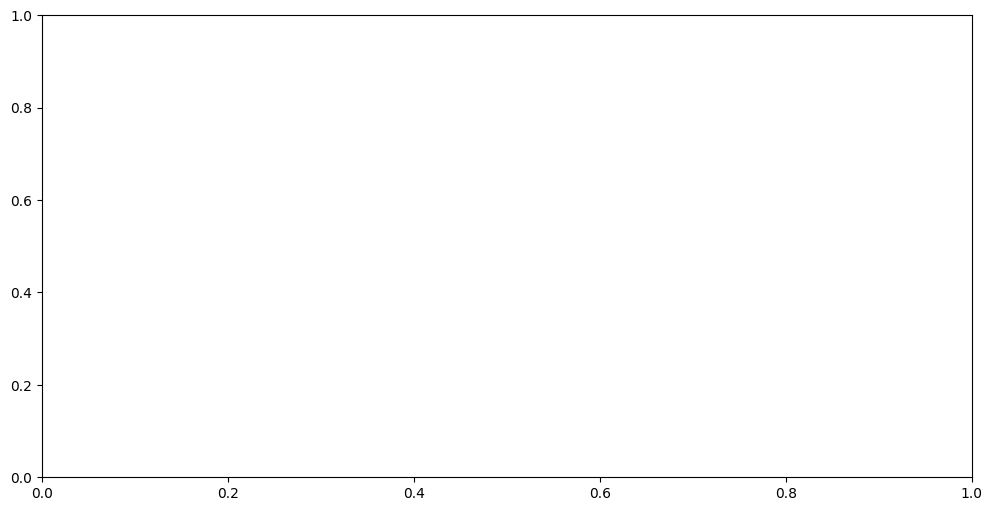

In [62]:
import matplotlib.pyplot as plt

def plot_cumulative_returns(portfolio_returns, capm_model, ff3):
    expected_returns = capm_model.predict(add_constant(ff3['Mkt-RF'].loc[portfolio_returns.index])) + ff3['RF'].loc[portfolio_returns.index]
    cum_portfolio_returns = (1 + portfolio_returns).cumprod()
    cum_expected_returns = (1 + expected_returns).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(cum_portfolio_returns, label='Value-weighted Portfolio')
    plt.plot(cum_expected_returns, label='CAPM-Implied Expected Portfolio Returns')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

capm_model_value_weighted, _, _, _ = estimate_models(portfolios['value']['return'], ff3, ff5)
plot_cumulative_returns(portfolios['value']['return'], capm_model_value_weighted, ff3)

In [ ]:
def estimate_carhart_subsamples(portfolio_returns, ff3, ff5, date_split):
    pre_returns = portfolio_returns.loc[:date_split]
    post_returns = portfolio_returns.loc[date_split:]

    pre_carhart_model = estimate_models(pre_returns, ff3, ff5)[2]
    post_carhart_model = estimate_models(post_returns, ff3, ff5)[2]

    print("Carhart Model (Pre-January 1st, 2010):")
    print(pre_carhart_model.summary())
    print("Carhart Model (Post-January 1st, 2010):")
    print(post_carhart_model.summary())

estimate_carhart_subsamples(portfolios['value']['return'], ff3, ff5, '2010-01-01')